<a href="https://colab.research.google.com/github/suleiman-odeh/NLP_Project_Team16/blob/main/fine_tuning/fine_tuning_direct_Qwen2_5_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers peft trl bitsandbytes accelerate datasets

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [3]:
"""
Setup
"""

import torch
import gc
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from unsloth import FastLanguageModel

print("Ready to go.")

/tmp/ipython-input-3124814905.py:16: UserWarning: WARNING: Unsloth should be imported before [trl, transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Ready to go.


In [5]:

max_seq_length = 2048
dtype = None
load_in_4bit = True
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-7B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # settings of the paper "I Never Said That"
    lora_alpha = 32,  # settings of the paper "I Never Said That"
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0.05, # settings of the paper "I Never Said That"
    bias = "none",
    use_gradient_checkpointing = "unsloth",

    random_state = 3407,
)
tokenizer.padding_side = "right"

print(f"Loaded UNSLOTH model: Qwen/Qwen2.5-7B")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.4 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Loaded UNSLOTH model: Qwen/Qwen2.5-7B


In [9]:
import pandas as pd
from datasets import Dataset

# Load dataset
filename = "QEvasion_cleaned.jsonl"

try:
    df = pd.read_json(filename, lines=True)
    print(f"Loaded {len(df)} rows using Pandas.")
except ValueError:
    df = pd.read_json(filename)
    print(f"Loaded {len(df)} rows using Pandas (Standard JSON).")

# Filter train and test sets
train_df = df[df['split_type'] == 'train']
test_df  = df[df['split_type'] == 'test']

print(f"   - Training pool: {len(train_df)}")
print(f"   - Test pool: {len(test_df)}")

# convert to hugging face dataset
full_train_dataset = Dataset.from_pandas(train_df)

# SPLIT (TRAIN vs VALIDATION)
dataset_split = full_train_dataset.train_test_split(test_size=0.2175, seed=42)

train_dataset = dataset_split['train']
eval_dataset = dataset_split['test']

print(f"Final Setup:")
print(f"   - Training Samples: {len(train_dataset)}")
print(f"   - Validation Samples: {len(eval_dataset)}")

# ---------------------------------------------------------
# prompt based on the paper
# ---------------------------------------------------------

def formatting_prompts_func(examples):
    output_texts = []

    instruction = (
        "Based on a part of the interview where the interviewer asks a set of questions, "
        "classify the type of answer the interviewee provided for the following question "
        "into one of these categories:\n"
        "1. Clear Reply - The information requested is explicitly stated (in the requested form)\n"
        "2. Clear Non-Reply - The information requested is not given at all due to ignorance, need for clarification or declining to answer\n"
        "3. Ambivalent - The information requested is given in an incomplete way e.g. the answer is too general, partial, implicit, dodging or deflection."
    )

    # Define columns
    answers = examples['cleaned_answer']
    questions = examples['question']
    labels = examples['clarity_label']
    is_batch = isinstance(questions, list)

    if not is_batch:
        questions = [questions]
        answers = [answers]
        labels = [labels]

    for i in range(len(questions)):
        # Get the label text
        label_text = str(labels[i])

        # Construct Prompt
        text = f"{instruction}\n\n### Part of the interview ###\n{answers[i]}\n\n### Question ###\n{questions[i]}\n\nLabel: {label_text}"

        # Add EOS token
        text = text + tokenizer.eos_token
        output_texts.append(text)

    return output_texts

# VERIFY
print("\n--- Sample Training Input ---")
print(formatting_prompts_func(train_dataset[:1])[0])

Loaded 3756 rows using Pandas.
   - Training pool: 3448
   - Test pool: 308
Final Setup:
   - Training Samples: 2698
   - Validation Samples: 750

--- Sample Training Input ---
Based on a part of the interview where the interviewer asks a set of questions, classify the type of answer the interviewee provided for the following question into one of these categories:
1. Clear Reply - The information requested is explicitly stated (in the requested form)
2. Clear Non-Reply - The information requested is not given at all due to ignorance, need for clarification or declining to answer
3. Ambivalent - The information requested is given in an incomplete way e.g. the answer is too general, partial, implicit, dodging or deflection.

### Part of the interview ###
Am I going to meet with the Iranians directly, is that the question?

### Question ###
Is it necessary to deal with Iranian directly?

Label: Clear Non-Reply<|endoftext|>


In [10]:
"""
Training Loop
"""

from trl import SFTTrainer, SFTConfig

model.config.use_cache = False
# define training arguments choice based on the settings used for OASST1 dataset, described in the paper
# QLORA: Efficient Finetuning of Quantized LLMs
training_args = SFTConfig(
    output_dir="./qwen-finetuned-evasion", # Where to save results

    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,         # Accumulate to simulate batch_size=16
    dataset_text_field="text",
    max_length=1024,
    gradient_checkpointing=True,           # Saves huge memory
    gradient_checkpointing_kwargs={"use_reentrant": False},
    learning_rate=2e-4,                    # Standard QLoRA learning rate
    num_train_epochs= 1,
    lr_scheduler_type="constant",          # from the paper
    logging_steps=10,                      # Print stats every 10 steps
    eval_strategy="steps",                # Check Validation Set
    eval_steps=50,                         # Check validation every 50 steps
    save_strategy="no",                    # Don't save intermediate checkpoints
    fp16=False,
    bf16=True,
    optim="paged_adamw_8bit",              # 8-bit Optimizer
    max_grad_norm=0.3,                     # from the paper
    adam_beta2=0.999,                      # from the paper
    report_to="none",                       # Prevents login popups
    packing=False
)

# Initialize trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
)

# Start training
print("Starting Training...")
trainer.train()

# Save the adapter
trainer.model.save_pretrained("./final_adapter_qwen")
tokenizer.save_pretrained("./final_adapter_qwen")
print("Training Complete. Adapter saved to './final_adapter_qwen'")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/2698 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/750 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


🦥 Unsloth: Padding-free auto-enabled, enabling faster training.
Starting Training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,698 | Num Epochs = 1 | Total steps = 169
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Step,Training Loss,Validation Loss
50,1.750500,1.706416
100,1.706500,1.625429
150,1.607300,1.557039


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training Complete. Adapter saved to './final_adapter_qwen'


In [11]:
"""
Inference: Check the testset
"""
from tqdm import tqdm
from unsloth import FastLanguageModel
import torch

# ENABLE UNSLOTH FAST INFERENCE
FastLanguageModel.for_inference(model)

# model in evaluation mode
model.eval()

def generate_prediction(question, answer):
    instruction = (
        "Based on a part of the interview where the interviewer asks a set of questions, "
        "classify the type of answer the interviewee provided for the following question "
        "into one of these categories:\n"
        "1. Clear Reply - The information requested is explicitly stated (in the requested form)\n"
        "2. Clear Non-Reply - The information requested is not given at all due to ignorance, need for clarification or declining to answer\n"
        "3. Ambivalent - The information requested is given in an incomplete way e.g. the answer is too general, partial, implicit, dodging or deflection."
    )

    # Construct prompt
    prompt = f"{instruction}\n\n### Part of the interview ###\n{answer}\n\n### Question ###\n{question}\n\nLabel:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # --- TOKEN SLICING ---
    input_len = inputs.input_ids.shape[1]
    generated_tokens = outputs[0][input_len:]
    prediction = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

    return prediction

# Generate predictions
print(f"Generating predictions for {len(test_df)} samples...")

# Enable Pandas Progress Bar
tqdm.pandas()

test_df.loc[:, 'predicted_label'] = test_df.progress_apply(
    lambda row: generate_prediction(row['question'], row['cleaned_answer']),
    axis=1
)

# Display a few results
print("\n--- Sample Predictions ---")
print(test_df[['question', 'clarity_label', 'predicted_label']].head(10))

Generating predictions for 308 samples...


100%|██████████| 308/308 [01:20<00:00,  3.83it/s]


--- Sample Predictions ---
                                               question clarity_label  \
3448   Inquiring about the status or information reg...    Ambivalent   
3449  Will you invite them to the White House to neg...    Ambivalent   
3450  Why was it necessary for Japan to drop the thr...    Ambivalent   
3451                  When will we see this resolution?    Ambivalent   
3452                Updating the figure of Iraqi deaths    Ambivalent   
3453  Do you think the Republican leader in the Hous...    Ambivalent   
3454  Do you ever feel like the walls are closing in...    Ambivalent   
3455   Is the demand for Israeli troops to pull out ...    Ambivalent   
3456  What are you offering the Arab nations to enco...    Ambivalent   
3457  Isn't Tehran's influence in the region growing...    Ambivalent   

     predicted_label  
3448      Ambivalent  
3449      Ambivalent  
3450      Ambivalent  
3451      Ambivalent  
3452      Ambivalent  
3453      Ambivalent  
3454   


/tmp/ipython-input-322196578.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'predicted_label'] = test_df.progress_apply(


Overall Accuracy: 0.7403

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.73      0.96      0.83       206
Clear Non-Reply       0.75      0.13      0.22        23
    Clear Reply       0.79      0.34      0.48        79

       accuracy                           0.74       308
      macro avg       0.76      0.48      0.51       308
   weighted avg       0.75      0.74      0.70       308



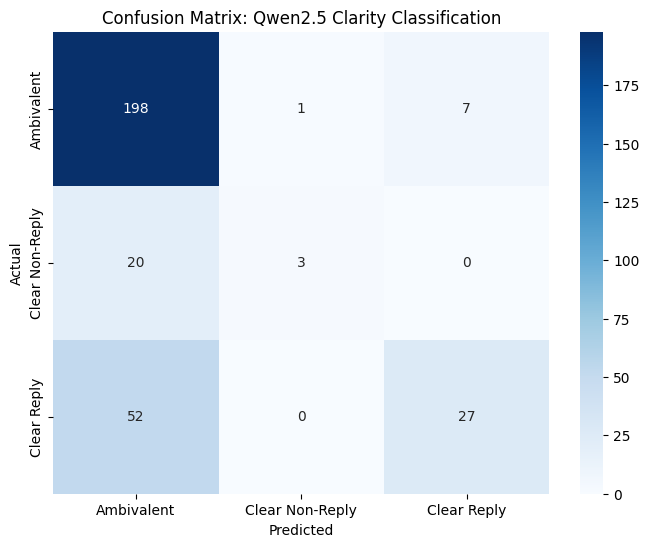

In [15]:
"""
Evaluation
"""
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure labels are treated as strings for comparison
y_true = test_df['clarity_label'].astype(str).tolist()
y_pred = test_df['predicted_label'].astype(str).tolist()

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}\n")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_true)),
            yticklabels=sorted(set(y_true)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Qwen2.5 Clarity Classification')
plt.show()

In [14]:
# Display a few results
print("\n--- Sample Predictions ---")
print(test_df[['question', 'clarity_label', 'predicted_label']].head(300))


--- Sample Predictions ---
                                               question clarity_label  \
3448   Inquiring about the status or information reg...    Ambivalent   
3449  Will you invite them to the White House to neg...    Ambivalent   
3450  Why was it necessary for Japan to drop the thr...    Ambivalent   
3451                  When will we see this resolution?    Ambivalent   
3452                Updating the figure of Iraqi deaths    Ambivalent   
...                                                 ...           ...   
3743  Non-Proliferation Treaty and Iran's knowledge ...    Ambivalent   
3744  Would you take the leading role, along with Pr...    Ambivalent   
3745  Does it concern you that the Beirut Airport ha...    Ambivalent   
3746                            What are your thoughts?   Clear Reply   
3747                               And if not, why not?   Clear Reply   

     predicted_label  
3448      Ambivalent  
3449      Ambivalent  
3450      Ambivalent  
345